# Actividad 5
**Esta semana nos centramos en el Análisis de Series de Tiempo**.\
Una serie de tiempo es cualquier conjunto de datos ordenados en el tiempo a intervalos iguales. Hemos visto que los datos climatológicos que descargamos del Servicio Meteorológico Nacional son datos diarios, se tiene una *serie de tiempo* para la **Precipitación**, una para la **Evaporación**, y las de las **Temperaturas (Máxima y Mínima)**. Podrían ser datos cada hora, cada minuto o quizá 10 datos por segundo, dependiendo del fenómeno que se desee estudiar.

In [2]:
#Importamos las bibliotecas a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# Para calcular las estacionalidad, tendencia y residuo
import statsmodels.api as sm
# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Empezamos por declarar el Dataframe que hemos estado haciendo con las variables de: Precip, Evap y TMAx y TMin. Para hacerlo más fácil de obtener los datos

In [3]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Tomar la dirección URL del archivo en formato 'raw'
url = 'https://raw.githubusercontent.com/Ferna45/Fisica-Computacional-1/master/Actividad-5/Base_de_Datos.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'TMax', 'TMin']
df_Comondu = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_BCS = df_Comondu.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_BajaC = df_BCS.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'TMax', 'TMin']
for cols in cols_list:
  df_BajaC[cols] = pd.to_numeric(df_BajaC[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_Calif = df_BajaC.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_Calif['Fecha']=pd.to_datetime(df_Calif['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_Calif['Año'] = df_Calif['Fecha'].dt.year
df_Calif['Mes'] = df_Calif['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_Calif.copy()
df_meteo.info()
print(df_meteo.head())
print(df_meteo.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21633 entries, 0 to 21632
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   21633 non-null  datetime64[ns]
 1   Precip  21582 non-null  float64       
 2   Evap    19448 non-null  float64       
 3   TMax    21576 non-null  float64       
 4   TMin    21588 non-null  float64       
 5   Año     21633 non-null  int64         
 6   Mes     21633 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 1.2+ MB
       Fecha  Precip  Evap  TMax  TMin   Año  Mes
0 1957-03-01     0.0   NaN  17.0  13.0  1957  Mar
1 1957-03-02     0.0   NaN  23.0   7.0  1957  Mar
2 1957-03-03     0.0   NaN  22.0   8.0  1957  Mar
3 1957-03-04     0.0   NaN  21.0   7.0  1957  Mar
4 1957-03-05     0.0   NaN  28.0  11.0  1957  Mar
           Fecha  Precip  Evap  TMax  TMin   Año  Mes
21628 2017-12-27     0.0   2.4  32.0  12.0  2017  Dec
21629 2

**Vamos a crear primero la serie de tiempo para poder usar el DataFrame**.

In [4]:
# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_Comondu = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_Comondu = df_meteo_Comondu.set_index('Fecha')

# Verificamos
df_meteo_Comondu.info()
print(df_meteo_Comondu.head())
print(df_meteo_Comondu.tail())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21633 entries, 1957-03-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  21582 non-null  float64
 1   Evap    19448 non-null  float64
 2   TMax    21576 non-null  float64
 3   TMin    21588 non-null  float64
 4   Año     21633 non-null  int64  
 5   Mes     21633 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ MB
            Precip  Evap  TMax  TMin   Año  Mes
Fecha                                          
1957-03-01     0.0   NaN  17.0  13.0  1957  Mar
1957-03-02     0.0   NaN  23.0   7.0  1957  Mar
1957-03-03     0.0   NaN  22.0   8.0  1957  Mar
1957-03-04     0.0   NaN  21.0   7.0  1957  Mar
1957-03-05     0.0   NaN  28.0  11.0  1957  Mar
            Precip  Evap  TMax  TMin   Año  Mes
Fecha                                          
2017-12-27     0.0   2.4  32.0  12.0  2017  Dec
2017-12-28     0.0   4.1  31.6  12.5 

*En mi caso voy a agrupar los datos de mi estación para poder leer los datos más fácil. Son **60 años** en total lo voy a dividir en dos grupo cada **30 años** para la realización de esta Actividad 5.*

In [5]:
# Seleccionaremos un conjunto de años de 30 años  
df_50 = df_meteo_Comondu[(df_meteo_Comondu['Año'] >= 1957) & (df_meteo_Comondu['Año'] < 1987)]
df_80 = df_meteo_Comondu[(df_meteo_Comondu['Año'] >= 1987) & (df_meteo_Comondu['Año'] < 2018)]

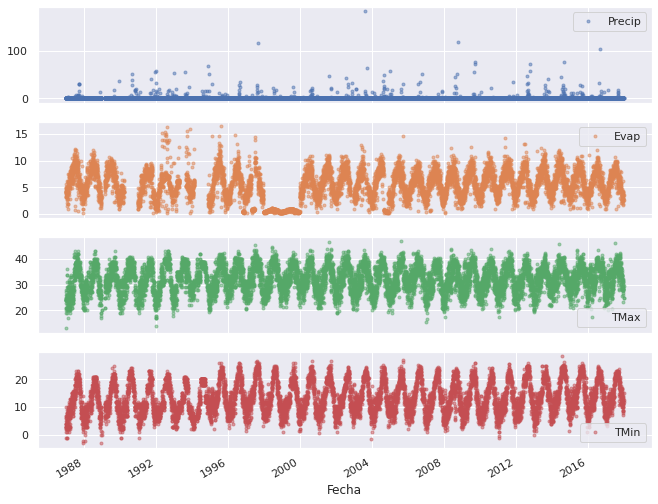

In [ ]:
# Podemos visualizar la colección de los últimos 30 años y ver si hay datos faltantes.
cols_plot = ['Precip', 'Evap', 'TMax', 'TMin']
ax_ylabels = ['Precip (mm)', 'Evap (mm)', 'TMax ºC', 'TMin (ºC)']
axes = df_80[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', 
                                  figsize=(11, 9), subplots=True)


# Actividad 1.-
Explora tus datos de **Precipitación** los últimos años **1990- fin de datos**.\
-Grafica todo el rango de datos utilizando la **función df.plot()**\
-Analiza un año específico completo\
-Grafica la estacionalidad de tus datos por mes utilizando la función **sns.boxplot()**. 

Variación en Precipitación promedio 86-57 : -0.059674073084657164
Variación en Precipitación promedio 87-2017 : 0.059674073084657164
Variación en Precipitación promedio 57-2017 : 0.059674073084657164


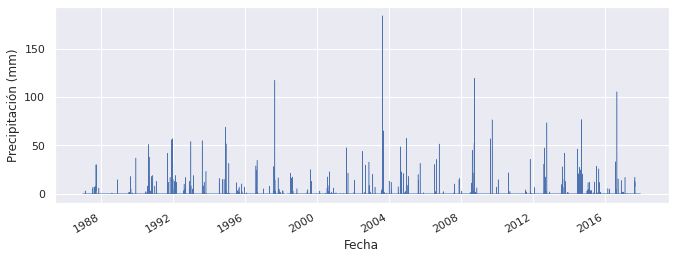

In [6]:
# Graficamos la Precipitación de los últimos 30 años (1987 hasta 2017)
sns.set(rc={'figure.figsize':(11, 4)})
Precip_ave_50 = df_50.Precip.mean()
Precip_ave_80 = df_80.Precip.mean()

df_80['Precip'].plot(linewidth=0.5);
plt.ylabel('Precipitación (mm)');

print('Variación en Precipitación promedio 86-57 :', Precip_ave_50-Precip_ave_80)
print('Variación en Precipitación promedio 87-2017 :', Precip_ave_80-Precip_ave_50)
print('Variación en Precipitación promedio 57-2017 :', Precip_ave_80-Precip_ave_50)

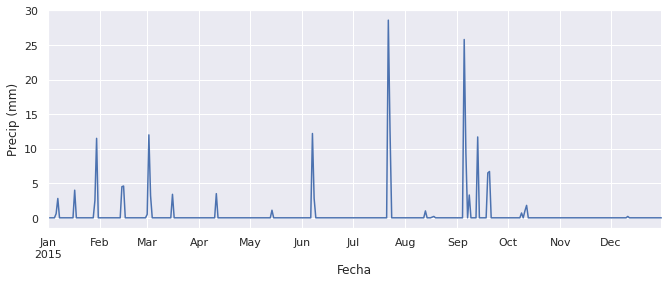

In [7]:
# Investigando un año de datos
ax = df_80.loc['2015', 'Precip'].plot()
ax.set_ylabel('Precip (mm)');

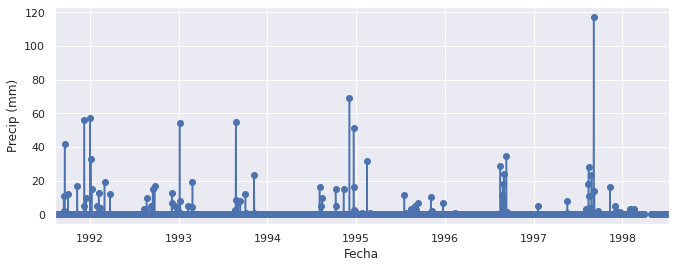

In [8]:
# Investigando un periodo de datos
ax = df_80.loc['1991-08-10':'1998-07-10', 'Precip'].plot(marker='o', linestyle='-')
ax.set_ylabel('Precip (mm)');

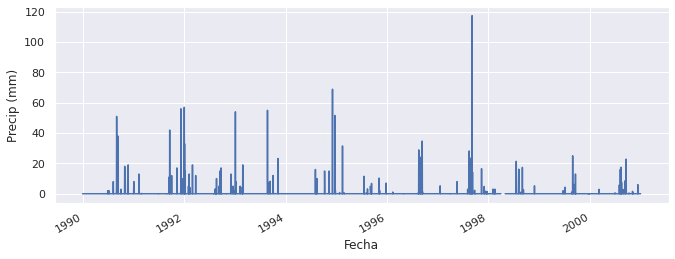

In [9]:
# Investigando un rango de datos
ax = df_80.loc['1990':'2000', 'Precip'].plot()
ax.set_ylabel('Precip (mm)');

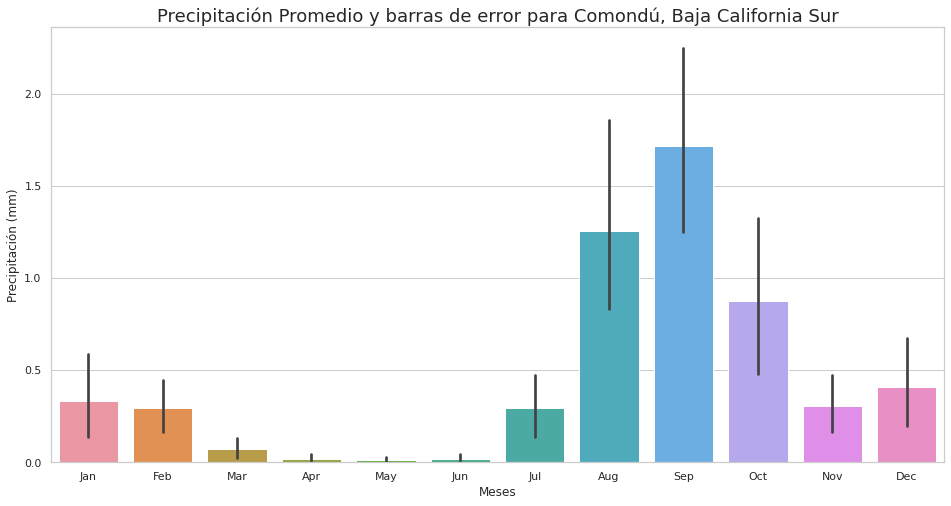

In [30]:
# Gráfica de Precipitación últimos 30 años agrupada por mes
sns.set_style('whitegrid')

# Para poner la gráfica más grande
plt.figure(figsize=(16,8))

# la gráfica
g =sns.barplot(x='Mes', y='Precip', data=df_80);

#Etiquetas
plt.xlabel('Meses')
plt.ylabel('Precipitación (mm)')
plt.title('Precipitación Promedio y barras de error para Comondú, Baja California Sur', fontsize=18)

plt.show()

# Actividad 2.- 
Explora tus datos de **Temperaturas Máxima y Mínima** de los **últimos 30 años** datos a partir de 1990.  Trata de construir dos subgráficas contiguas. 

-Grafica todo el rango de datos utilizando la **función df.plot()**, incluye una línea punteada mostrando el promedio.\
-Analiza un año específico completo para las **dos Temperaturas**.\
-Grafica la estacionalidad filtrando tus datos por mes y utilizando la función **sns.boxplot()**, incluye una ***línea punteada mostrando el promedio***.  

Variación ºC TMax promedio 87-57 : 1.6026931015043218


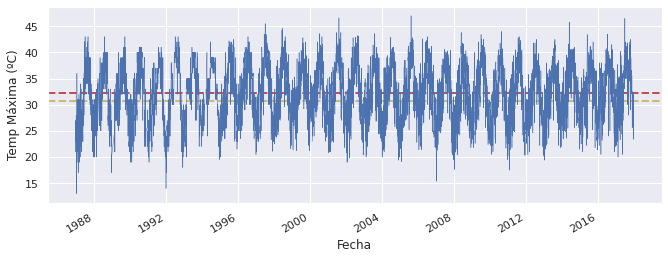

In [11]:
# Graficamos la TMax de los últimos 30 años (1987 hasta 2017)
sns.set(rc={'figure.figsize':(11, 4)})
Tmax_ave_80 = df_80.TMax.mean()
Tmax_ave_50 = df_50.TMax.mean()
plt.axhline(Tmax_ave_80, color = 'r', linestyle='--', linewidth=2);
plt.axhline(Tmax_ave_50, color = 'y', linestyle='--', linewidth=2);
df_80['TMax'].plot(linewidth=0.5);
plt.ylabel('Temp Máxima (ºC)');
print('Variación ºC TMax promedio 87-57 :', Tmax_ave_80-Tmax_ave_50)

Variación ºC TMin promedio 87-57 : 0.31043181914498774


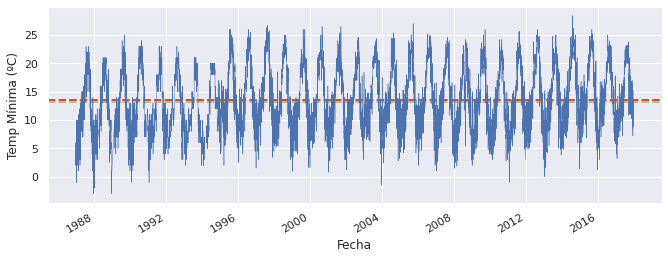

In [13]:
# Graficamos la TMin de los últimos 30 años (1987-hasta 2017)
sns.set(rc={'figure.figsize':(11, 4)})
Tmin_ave_80 = df_80.TMin.mean()
Tmin_ave_50 = df_50.TMin.mean()
plt.axhline(Tmin_ave_80, color = 'r', linestyle='--', linewidth=2);
plt.axhline(Tmin_ave_50, color = 'y', linestyle='--', linewidth=2);

df_80['TMin'].plot(linewidth=0.5);
plt.ylabel('Temp Mínima (ºC)');
print('Variación ºC TMin promedio 87-57 :', Tmin_ave_80-Tmin_ave_50)

*Análisis de Datos para las dos Temperaturas*.

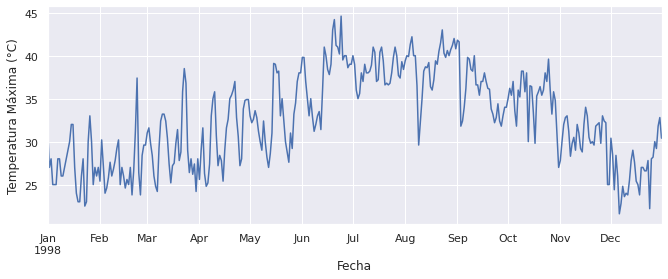

In [14]:
# Investigando un año de datos
ax = df_80.loc['1998', 'TMax'].plot()
ax.set_ylabel('Temperatura Máxima (°C)');


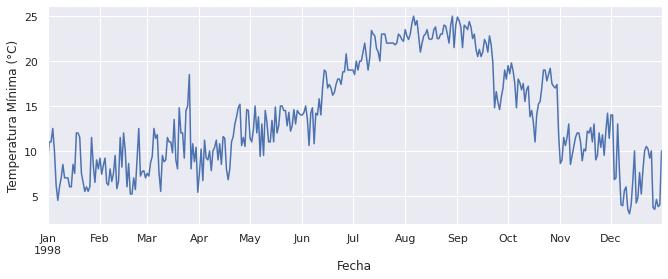

In [ ]:
# Investigando un año de datos
ax = df_80.loc['1998', 'TMin'].plot()
ax.set_ylabel('Temperatura Mínima (°C)');


*Estacionalidad por mes*

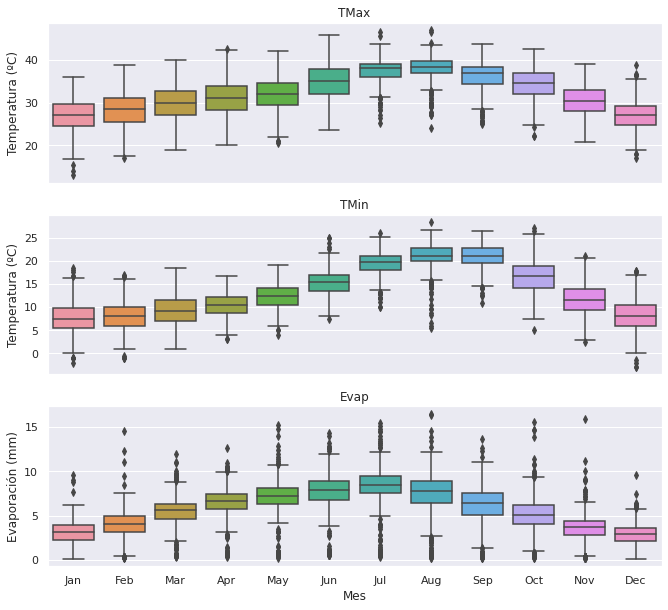

In [85]:
# Analizando Estacionalidad de los datos, similar a lo que ya hicimos anteriormente.
# Dos gráficas en una
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

for name, ax in zip(['TMax', 'TMin', 'Evap'], axes):
  sns.boxplot(data=df_80, x='Mes', y=name, ax=ax)
  if name != 'Evap':
    ax.set_ylabel('Temperatura (ºC)')
  else: 
    ax.set_ylabel('Evaporación (mm)')
  ax.set_title(name)
# Elimina la etiqueta del eje x excepto la de la subgráfica de abajo 
  if ax != axes[-1]:
    ax.set_xlabel('')


# Actividad 3
Realizar el mismo análisis que en la Actividad 2, pero para la variable de **Evaporación**.

Variación mm Evaporación promedio 87-57 : -0.6398207949422359


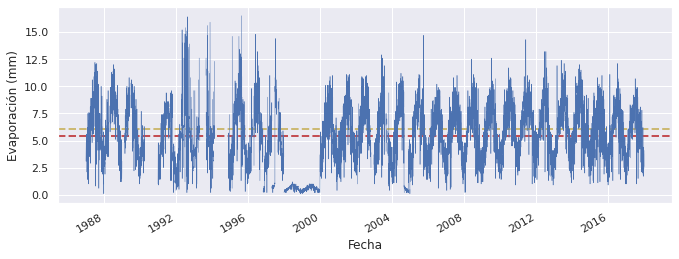

In [17]:
# Graficamos la Evaporación de los últimos 30 años (1987 hasta 2017)
sns.set(rc={'figure.figsize':(11, 4)})
Evap_ave_80 = df_80.Evap.mean()
Evap_ave_50 = df_50.Evap.mean()
plt.axhline(Evap_ave_80, color = 'r', linestyle='--', linewidth=2);
plt.axhline(Evap_ave_50, color = 'y', linestyle='--', linewidth=2);
df_80['Evap'].plot(linewidth=0.5);
plt.ylabel('Evaporación (mm)');
print('Variación mm Evaporación promedio 87-57 :', Evap_ave_80-Evap_ave_50)

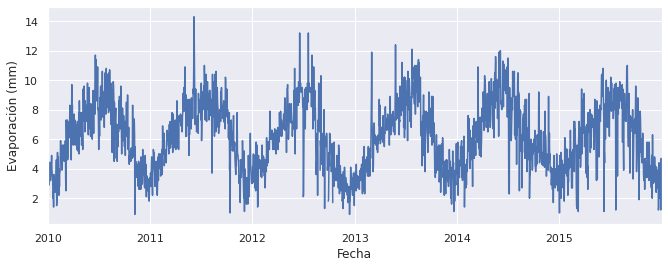

In [16]:
# INVESTIGANDO UN RANGO DE DATOS EVAPORACION
ax = df_80.loc['2010':'2015', 'Evap'].plot()
ax.set_ylabel('Evaporación (mm)');

# Actividad 4
Crea nuevos DataFrames de las **Temperaturas** y la **Evaporación** con promedios móviles de *7, 30 y 365 días*, utilizando la función **df.rolling()**.\
Explora tus datos:\
-Para un año de datos, contrastando los datos diarios con el promedio móvil de 7 y 30 días.\
-Explora para 10 o más años de datos, contrastando los datos diarios con las gráficas de promedio móvil de 365 días.

In [21]:
# Suavizando la curva de TMax, utilizando Promedios Móviles (7,30 y 365 días)
data_cols = ['Evap', 'TMax', 'TMin']
df_80_7d = df_80[data_cols].rolling(7, center=True,min_periods=1).mean()
df_80_30d = df_80[data_cols].rolling(30, center=True, min_periods=1).mean()
df_80_365d = df_80[data_cols].rolling(365, center=True, min_periods=1).mean()

df_80_365d

,Evap,TMax,TMin
Fecha,,,
1987-01-01,6.271823,26.448087,8.579235
1987-01-02,6.289560,26.494565,8.603261
1987-01-03,6.306011,26.529730,8.637838
1987-01-04,6.322826,26.559140,8.688172
1987-01-05,6.331351,26.604278,8.721925
...,...,...,...
2017-12-27,6.008602,35.304278,17.529947
2017-12-28,5.997297,35.284409,17.516667
2017-12-29,5.982609,35.287027,17.500541


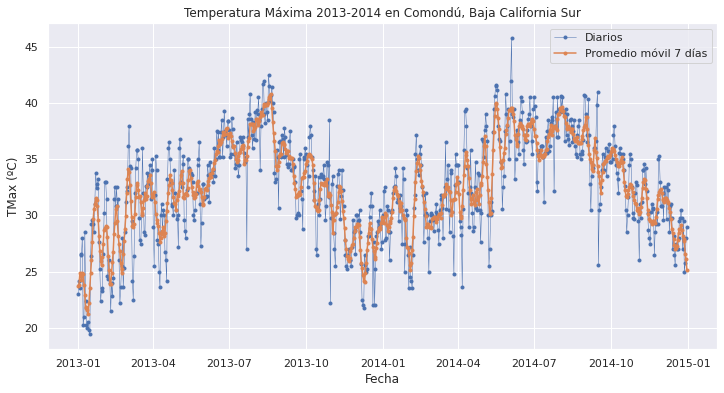

In [49]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2013-01', '2014-12'

# Contraste de la gráfica de datos diarios y la de promedio móvil de 7 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMax'],
marker='.', linestyle='-', linewidth=0.5, label='Diarios')
ax.plot(df_80_7d.loc[start:end, 'TMax'], marker='.', linestyle='-', label='Promedio móvil 7 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('TMax (ºC)')
ax.set_title('Temperatura Máxima 2013-2014 en Comondú, Baja California Sur')
ax.legend();

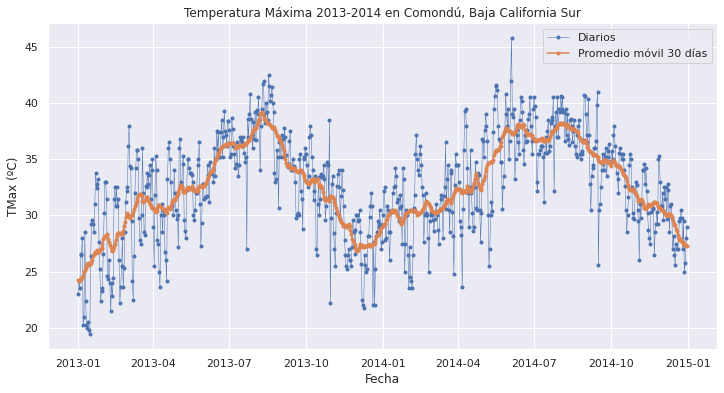

In [48]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2013-01', '2014-12'

# Contraste de la gráfica de datos diarios y la de promedio móvil de 7 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMax'],
marker='.', linestyle='-', linewidth=0.5, label='Diarios')
ax.plot(df_80_30d.loc[start:end, 'TMax'], marker='.', linestyle='-', label='Promedio móvil 30 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('TMax (ºC)')
ax.set_title('Temperatura Máxima 2013-2014 en Comondú, Baja California Sur')
ax.legend();

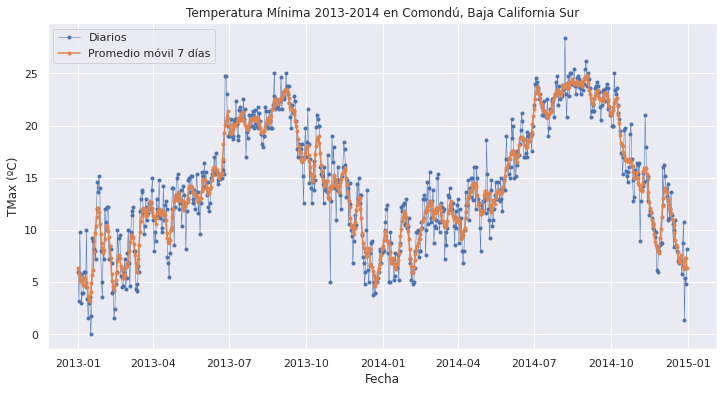

In [47]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2013-01', '2014-12'

# Contraste de la gráfica de datos diarios y la de promedio móvil de 30 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMin'],
marker='.', linestyle='-', linewidth=0.5, label='Diarios')
ax.plot(df_80_7d.loc[start:end, 'TMin'], marker='.', linestyle='-', label='Promedio móvil 7 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('TMax (ºC)')
ax.set_title('Temperatura Mínima 2013-2014 en Comondú, Baja California Sur')
ax.legend();

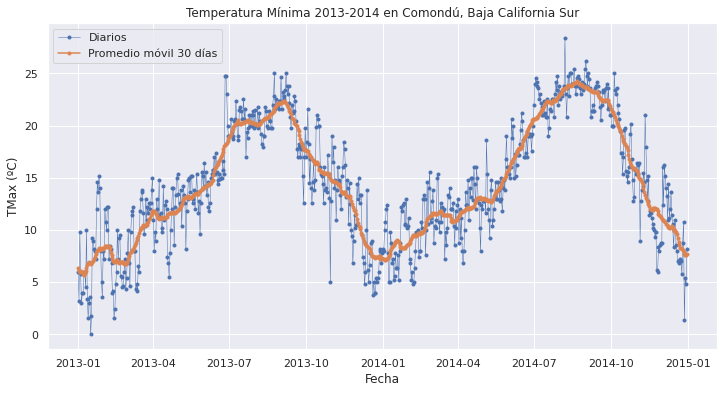

In [46]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2013-01', '2014-12'

# Contraste de la gráfica de datos diarios y la de promedio móvil de 30 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMin'],
marker='.', linestyle='-', linewidth=0.5, label='Diarios')
ax.plot(df_80_30d.loc[start:end, 'TMin'], marker='.', linestyle='-', label='Promedio móvil 30 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('TMax (ºC)')
ax.set_title('Temperatura Mínima 2013-2014 en Comondú, Baja California Sur')
ax.legend();

**Temperatura Máxima**

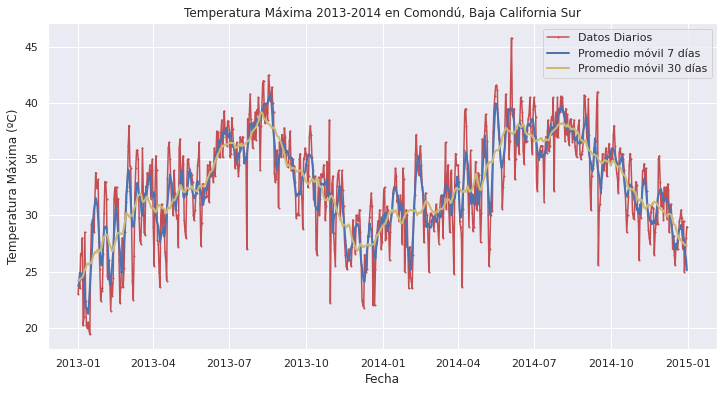

In [45]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2013-01', '2014-12'

# Contraste de la gráfica de datos diarios y promedio móvil de 7 y 30 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMax'],
marker='.', markersize=2, linestyle='-', color='r',label='Datos Diarios')
ax.plot(df_80_7d.loc[start:end, 'TMax'], linestyle='-', linewidth=2, label='Promedio móvil 7 días')
ax.plot(df_80_30d.loc[start:end, 'TMax'], linestyle='-', color= 'y', linewidth=2, label='Promedio móvil 30 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura Máxima (ºC)')
ax.set_title('Temperatura Máxima 2013-2014 en Comondú, Baja California Sur')
ax.legend();

**Temperaturas Mínimas**

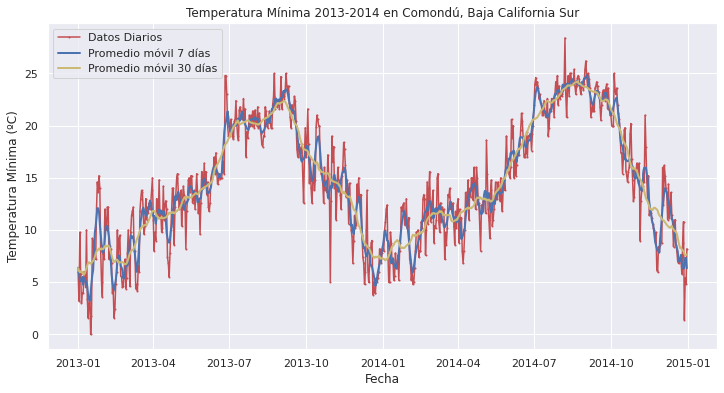

In [44]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2013-01', '2014-12'

# Contraste de la gráfica de datos diarios y promedio móvil de 7 y 30 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMin'],
marker='.', markersize=2, linestyle='-', color='r',label='Datos Diarios')
ax.plot(df_80_7d.loc[start:end, 'TMin'], linestyle='-', linewidth=2, label='Promedio móvil 7 días')
ax.plot(df_80_30d.loc[start:end, 'TMin'], linestyle='-', color= 'y', linewidth=2, label='Promedio móvil 30 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura Mínima (ºC)')
ax.set_title('Temperatura Mínima 2013-2014 en Comondú, Baja California Sur')
ax.legend();

**Evaporación**

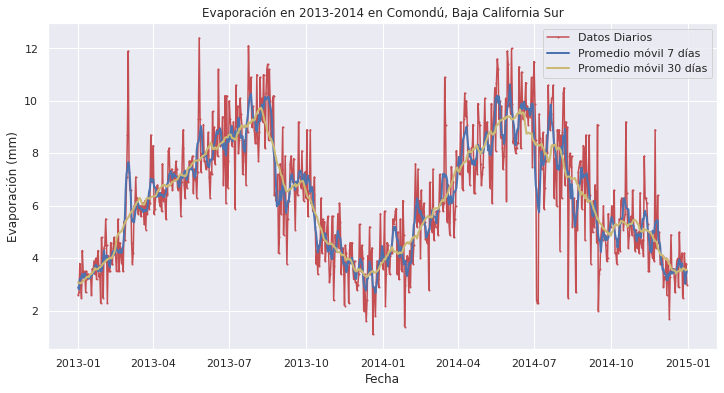

In [43]:
# Fechas de inicio y fin, para filtrar la información
start, end = '2013-01', '2014-12'

# Contraste de la gráfica de datos diarios y promedio móvil de 7 y 30 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'Evap'],
marker='.', markersize=2, linestyle='-', color='r',label='Datos Diarios')
ax.plot(df_80_7d.loc[start:end, 'Evap'], linestyle='-', linewidth=2, label='Promedio móvil 7 días')
ax.plot(df_80_30d.loc[start:end, 'Evap'], linestyle='-', color= 'y', linewidth=2, label='Promedio móvil 30 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Evaporación (mm)')
ax.set_title('Evaporación en 2013-2014 en Comondú, Baja California Sur')
ax.legend();

**Análisis de 10 años**

*Temperatura Máxima*

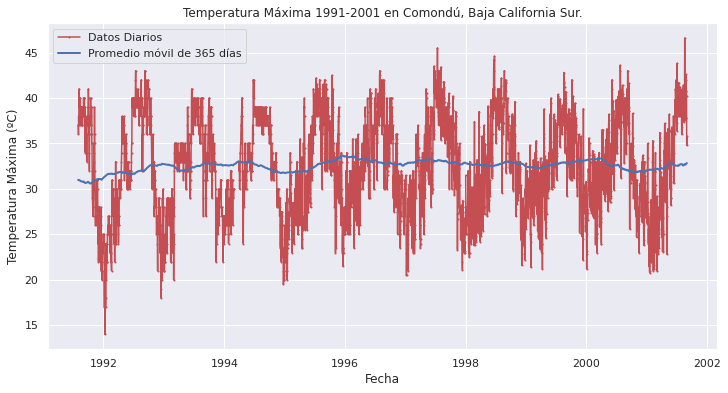

In [51]:
# Fechas de inicio y fin, para filtrar la información
start, end = '1991-08', '2001-08'

# Contraste de la gráfica de datos diarios y promedio móvil de 365 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMax'],
marker='.', markersize=2, linestyle='-', color='r',label='Datos Diarios')
ax.plot(df_80_365d.loc[start:end, 'TMax'], linestyle='-', linewidth=2, label='Promedio móvil de 365 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura Máxima (ºC)')
ax.set_title('Temperatura Máxima 1991-2001 en Comondú, Baja California Sur.')
ax.legend();

*Temperatura Mínima*

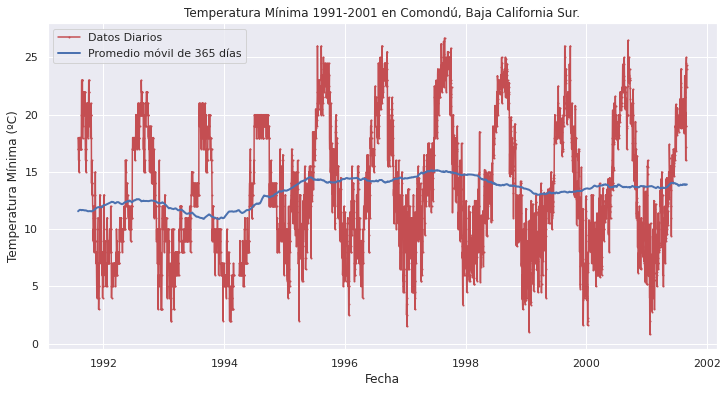

In [52]:
# Fechas de inicio y fin, para filtrar la información
start, end = '1991-08', '2001-08'

# Contraste de la gráfica de datos diarios y promedio móvil de 365 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'TMin'],
marker='.', markersize=2, linestyle='-', color='r',label='Datos Diarios')
ax.plot(df_80_365d.loc[start:end, 'TMin'], linestyle='-', linewidth=2, label='Promedio móvil de 365 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Temperatura Mínima (ºC)')
ax.set_title('Temperatura Mínima 1991-2001 en Comondú, Baja California Sur.')
ax.legend();

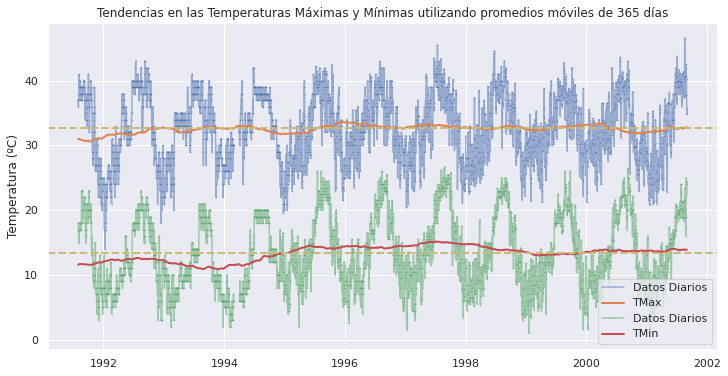

In [53]:
# Graficas de promedios móviles de 365 días para las variables de las Temperaturas  
sns.set(rc={'figure.figsize':(12, 6)})

start, end = '1991-08', '2001-08'

fig, ax = plt.subplots()
for nm in ['TMax', 'TMin']:
    ax.plot(df_80.loc[start:end, nm], marker='.', markersize=1, linestyle='-', alpha=0.5, label='Datos Diarios')
    ax.plot(df_80_365d.loc[start:end, nm], linewidth=2, label=nm)
    plt.axhline(df_80.loc[start:end, nm].mean(), color = 'y', linestyle='--', linewidth=2);
    
    ax.legend()
    ax.set_ylabel('Temperatura (ºC)')
    ax.set_title('Tendencias en las Temperaturas Máximas y Mínimas utilizando promedios móviles de 365 días');


*Evaporación*

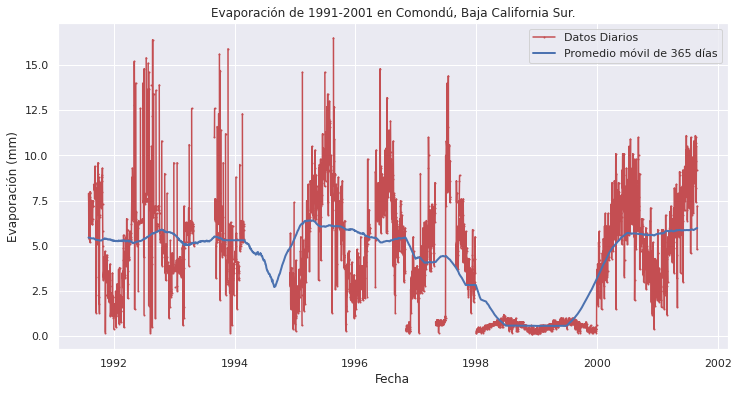

In [55]:
# Fechas de inicio y fin, para filtrar la información
start, end = '1991-08', '2001-08'

# Contraste de la gráfica de datos diarios y promedio móvil de 365 días 
sns.set(rc={'figure.figsize':(12, 6)})

fig, ax = plt.subplots()
ax.plot(df_80.loc[start:end, 'Evap'],
marker='.', markersize=2, linestyle='-', color='r',label='Datos Diarios')
ax.plot(df_80_365d.loc[start:end, 'Evap'], linestyle='-', linewidth=2, label='Promedio móvil de 365 días')

ax.set_xlabel('Fecha')
ax.set_ylabel('Evaporación (mm)')
ax.set_title('Evaporación de 1991-2001 en Comondú, Baja California Sur.')
ax.legend();

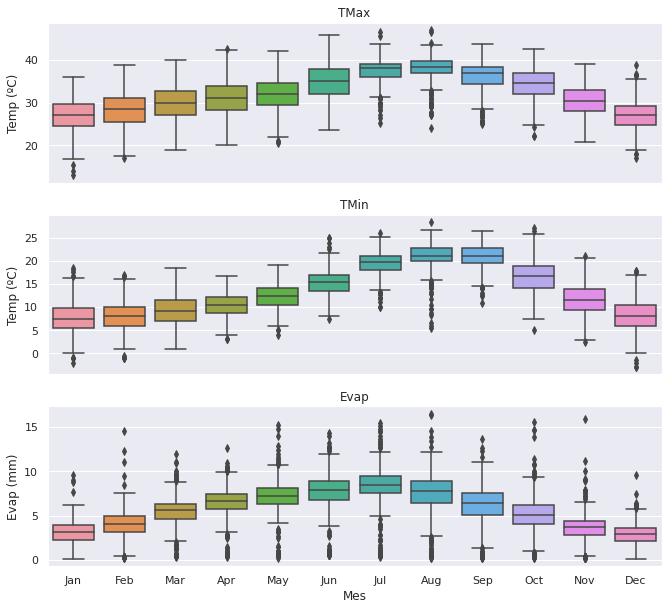

In [58]:
# Analizando Estacionalidad de los datos, similar a lo que ya hicimos anteriormente.
# Dos gráficas en una
fig, axes = plt.subplots(3, 1, figsize=(11, 10), sharex=True)

for name, ax in zip(['TMax', 'TMin', 'Evap'], axes):
  sns.boxplot(data=df_80, x='Mes', y=name, ax=ax)
  if name != 'Evap':
    ax.set_ylabel('Temp (ºC)')
  else: 
    ax.set_ylabel('Evap (mm)')
  ax.set_title(name)
# Elimina la etiqueta del eje x excepto la de la subgráfica de abajo 
  if ax != axes[-1]:
    ax.set_xlabel('')

# Actividad 5
Utiliza la biblioteca **statsmodels.tsa** de Python, para realizar una descomposición de una serie de tiempo: *Serie Observada = Tendencia + Estacionalidad + Residuo*.\
Aplica la función **seasonal_decompose** para lograr esto, a los datos de **Temperaturas Tmax y Tmin**, y si tienes datos de **Evaporación**, selecciona un periodo que haya datos. La función de **seasonal_decompose** aplica su propio promedio móvil a las series de datos para su análisis. 

**Temperatura Máxima**

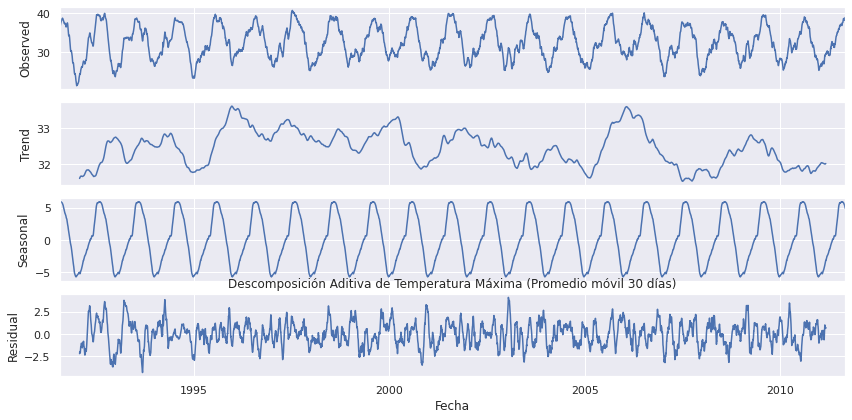

In [57]:
# Caso: Uso de datos con promedio móvil de 30 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '1991-08', '2011-08'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resTmax = sm.tsa.seasonal_decompose(df_80_30d.loc[start:end, 'TMax'].interpolate(), freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Temperatura Máxima (Promedio móvil 30 días)');

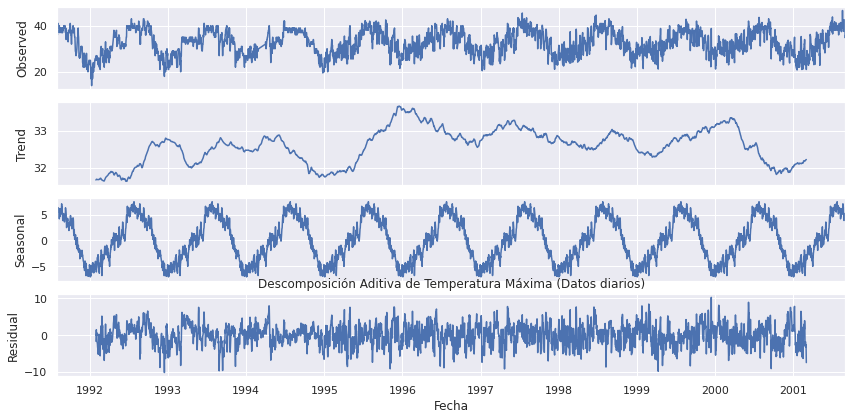

In [60]:
# Caso: Uso de datos diarios 
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '1991-08', '2001-08'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resTmax = sm.tsa.seasonal_decompose(df_80.loc[start:end, 'TMax'].interpolate(), freq=decompfreq, model='additive')
resTmax.plot()

plt.title('Descomposición Aditiva de Temperatura Máxima (Datos diarios)');


In [67]:
resTmax.trend.describe()

count    3320.000000
mean       32.600789
std         0.463556
min        31.627397
25%        32.293767
50%        32.662757
75%        32.902740
max        33.672603
Name: TMax, dtype: float64

**Temperatura Mínima**

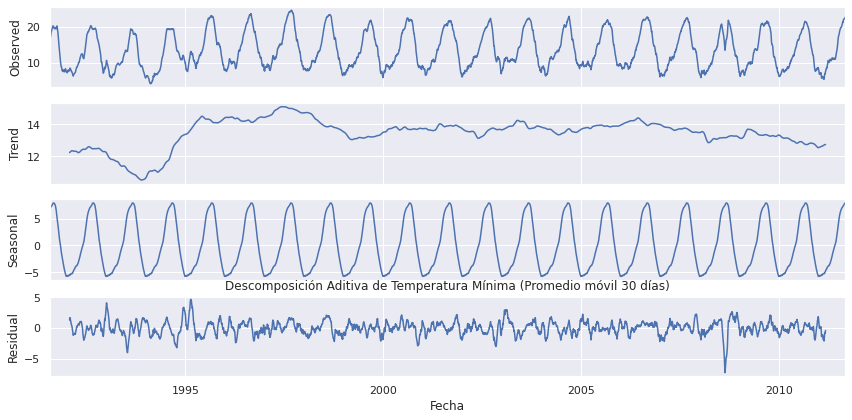

In [61]:
# Caso: Uso de datos con promedio móvil de 30 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '1991-08', '2011-08'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resTmin = sm.tsa.seasonal_decompose(df_80_30d.loc[start:end, 'TMin'].interpolate(), freq=decompfreq, model='additive')
resTmin.plot()

plt.title('Descomposición Aditiva de Temperatura Mínima (Promedio móvil 30 días)');

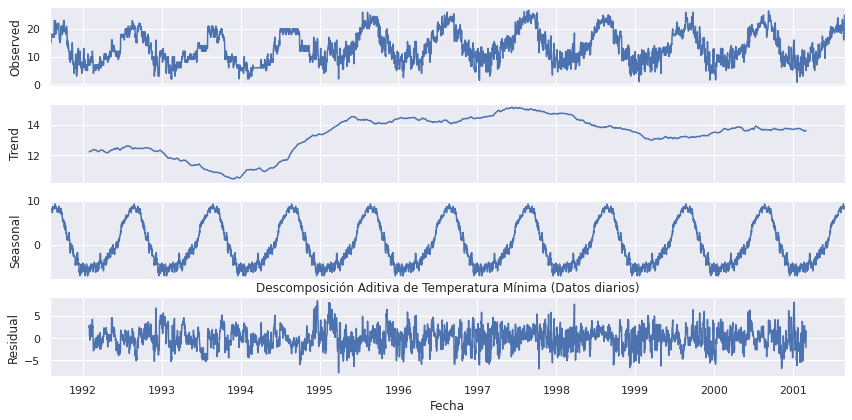

In [63]:
# Caso: Uso de datos diarios 
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '1991-08', '2001-08'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resTmin = sm.tsa.seasonal_decompose(df_80.loc[start:end, 'TMin'].interpolate(), freq=decompfreq, model='additive')
resTmin.plot()

plt.title('Descomposición Aditiva de Temperatura Mínima (Datos diarios)');

In [68]:
resTmin.trend.describe()

count    3320.000000
mean       13.321369
std         1.213732
min        10.463014
25%        12.454795
50%        13.675753
75%        14.278562
max        15.147945
Name: TMin, dtype: float64

**Evaporación**

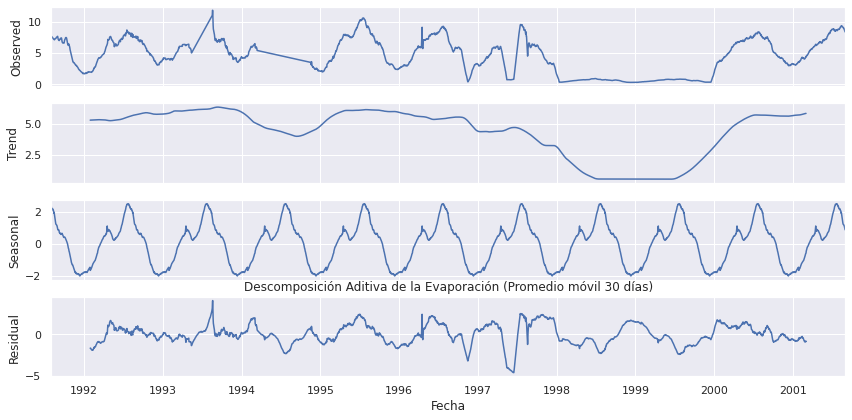

In [65]:
# Caso: Uso de datos con promedio móvil de 30 días.
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '1991-08', '2001-08'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resEvap = sm.tsa.seasonal_decompose(df_80_30d.loc[start:end, 'Evap'].interpolate(), freq=decompfreq, model='additive')
resEvap.plot()

plt.title('Descomposición Aditiva de la Evaporación (Promedio móvil 30 días)');

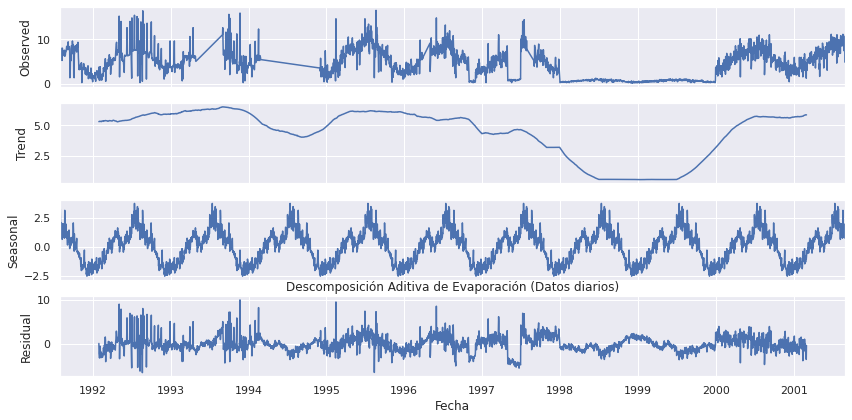

In [66]:
# Caso: Uso de datos diarios 
# Descomposición de Series de Tiempo 
# Uso de la biblioteca 'statsmodel' (agregada en la celda 1)
# import statsmodels.api as sm 

# Modelo Aditivo: Observado = Tendencia + Estacionalidad + Residuo

# Tamaño de la figura
sns.set(rc={'figure.figsize':(12, 6)})
# Periodo de datos completos (No funciona cuando hace falta un rango de datos)
start, end = '1991-08', '2001-08'

# Ciclo anual 365 días (Por las Estaciones)
decompfreq = 365

# Uso del modelo 'statsmodel' para el análisis de series de tiempo(sm.tsa) 


resEvap = sm.tsa.seasonal_decompose(df_80.loc[start:end, 'Evap'].interpolate(), freq=decompfreq, model='additive')
resEvap.plot()

plt.title('Descomposición Aditiva de Evaporación (Datos diarios)');

In [69]:
resEvap.trend.describe()

count    3320.000000
mean        4.385663
std         1.914224
min         0.569589
25%         3.495959
50%         5.313904
75%         5.841605
max         6.474948
Name: Evap, dtype: float64

# Actividad 6
Por favor explorar visualmente si se observa un cambio en la **distribución de Temperaturas (histogramas y kde)**, sobreponiendo dos histogramas de **dos periodos de 30 años contiguos**.\
Utiliza la función de **Seaborn: sns.distplot**. Agrega una línea vertical punteada indicando el valor del promedio de cada grupo de datos.  

**Temperatura Máxima**

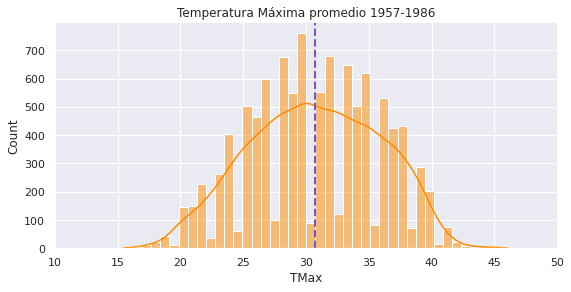

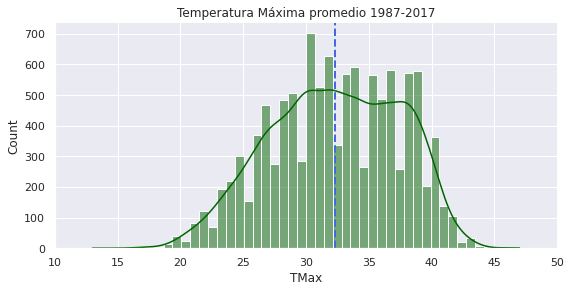

Temperatura máxima promedio del periodo 1957-1986 =  30.6880122852481 ºC
Temperatura máxima promedio del periodo 1987-2017 = 32.29070538675242 ºC
Distribución de la Temperatura Máxima del periodo 1957-1986 =  5.1764567816498435 ºC
Distribución de la Temperatura Máxima del periodo 1987-2017 =  5.135593024946048 ºC


In [83]:
# Gráfica de distribuciones de Temperaturas Tmax 

g1 = sns.displot(df_50.TMax, kde=True, color='darkorange', height=4, aspect=2);
plt.axvline(df_50.TMax.mean(), linestyle='--', linewidth=2, color='slateblue');

g2 = sns.displot(df_80.TMax, kde=True, color='darkgreen', height=4, aspect=2);
plt.axvline(df_80.TMax.mean(), linestyle='--', linewidth=2, color='royalblue');

g1.set(title='Temperatura Máxima promedio 1957-1986');
g2.set(title='Temperatura Máxima promedio 1987-2017');

g1.set(xlim=(10,50))
g2.set(xlim=(10,50))


plt.show();

print('Temperatura máxima promedio del periodo 1957-1986 = ', df_50.TMax.mean(), 'ºC' )
print('Temperatura máxima promedio del periodo 1987-2017 =', df_80.TMax.mean(), 'ºC' )

print('Distribución de la Temperatura Máxima del periodo 1957-1986 = ', df_50.TMax.std(), 'ºC' )
print('Distribución de la Temperatura Máxima del periodo 1987-2017 = ', df_80.TMax.std(), 'ºC' )

**Temperatura Mínima**

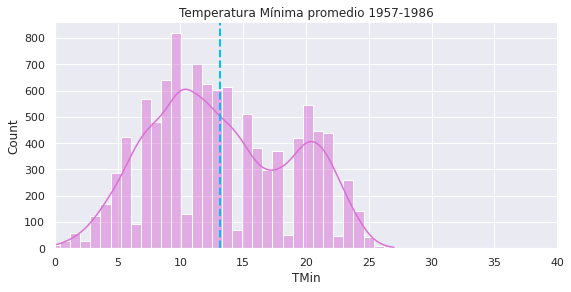

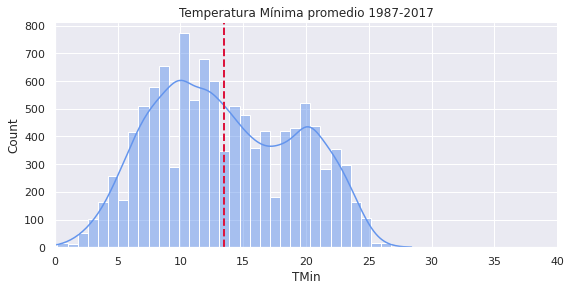

Temperatura mínima promedio del periodo 1957-1986 =  13.190616004605642 ºC
Temperatura mínima promedio del periodo 1986-2017 =  13.50104782375063 ºC
Distribución de la Temperatura Mínima del periodo 1957-1986 =  5.5727859301471305 ºC
Distribución de la Temperatura Mínima del periodo 1987-2017 =  5.625542937347717 ºC


In [78]:
# Gráfica de distribuciones de Temperaturas Tmin 

g1 = sns.displot(df_50.TMin, kde=True, color='orchid', height=4, aspect=2);
plt.axvline(df_50.TMin.mean(), linestyle='--', linewidth=2, color='deepskyblue');

g2 = sns.displot(df_80.TMin, kde=True, color='cornflowerblue', height=4, aspect=2);
plt.axvline(df_80.TMin.mean(), linestyle='--', linewidth=2, color='crimson');

g1.set(title='Temperatura Mínima promedio 1957-1986');
g2.set(title='Temperatura Mínima promedio 1987-2017');

g1.set(xlim=(0,40))
g2.set(xlim=(0,40))

plt.show();

print('Temperatura mínima promedio del periodo 1957-1986 = ', df_50.TMin.mean(), 'ºC' )
print('Temperatura mínima promedio del periodo 1986-2017 = ', df_80.TMin.mean(), 'ºC' )

print('Distribución de la Temperatura Mínima del periodo 1957-1986 = ', df_50.TMin.std(), 'ºC' )
print('Distribución de la Temperatura Mínima del periodo 1987-2017 = ', df_80.TMin.std(), 'ºC' )

**Evaporación**

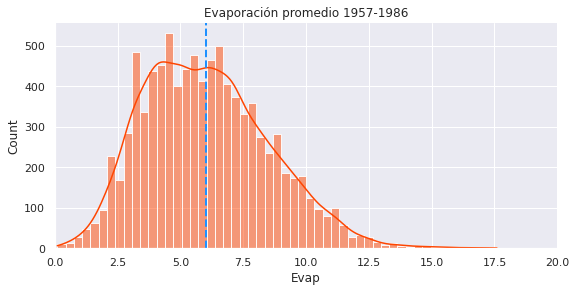

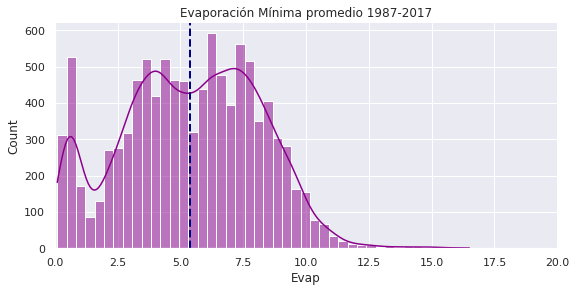

Evaporación promedio del periodo 1957-1986 =  6.0355338135684296 mm
Evaporación promedio del periodo 1986-2017 =  5.395713018626194 mm
Distribución de la Evaporación del periodo 1957-1986 =  2.484995966648587 mm
Distribución de la Evaporación del periodo 1987-2017 =  2.7314419335039295 mm


In [82]:
# Gráfica de distribuciones de la evaporación

g1 = sns.displot(df_50.Evap, kde=True, color='orangered', height=4, aspect=2);
plt.axvline(df_50.Evap.mean(), linestyle='--', linewidth=2, color='dodgerblue');

g2 = sns.displot(df_80.Evap, kde=True, color='darkmagenta', height=4, aspect=2);
plt.axvline(df_80.Evap.mean(), linestyle='--', linewidth=2, color='navy');

g1.set(title='Evaporación promedio 1957-1986');
g2.set(title='Evaporación Mínima promedio 1987-2017');

g1.set(xlim=(0,20))
g2.set(xlim=(0,20))

plt.show();

print('Evaporación promedio del periodo 1957-1986 = ', df_50.Evap.mean(), 'mm' )
print('Evaporación promedio del periodo 1986-2017 = ', df_80.Evap.mean(), 'mm' )

print('Distribución de la Evaporación del periodo 1957-1986 = ', df_50.Evap.std(), 'mm' )
print('Distribución de la Evaporación del periodo 1987-2017 = ', df_80.Evap.std(), 'mm' )